<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [3]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [4]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [5]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [6]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [7]:
# Check Missing Values
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [8]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [9]:
# Apply MICE imputer
#imputer = IterativeImputer(random_state=0)
#df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
#df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
df_imputed = df.copy()
df_imputed.fillna(df.mean(), inplace=True)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [10]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [11]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [12]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [13]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




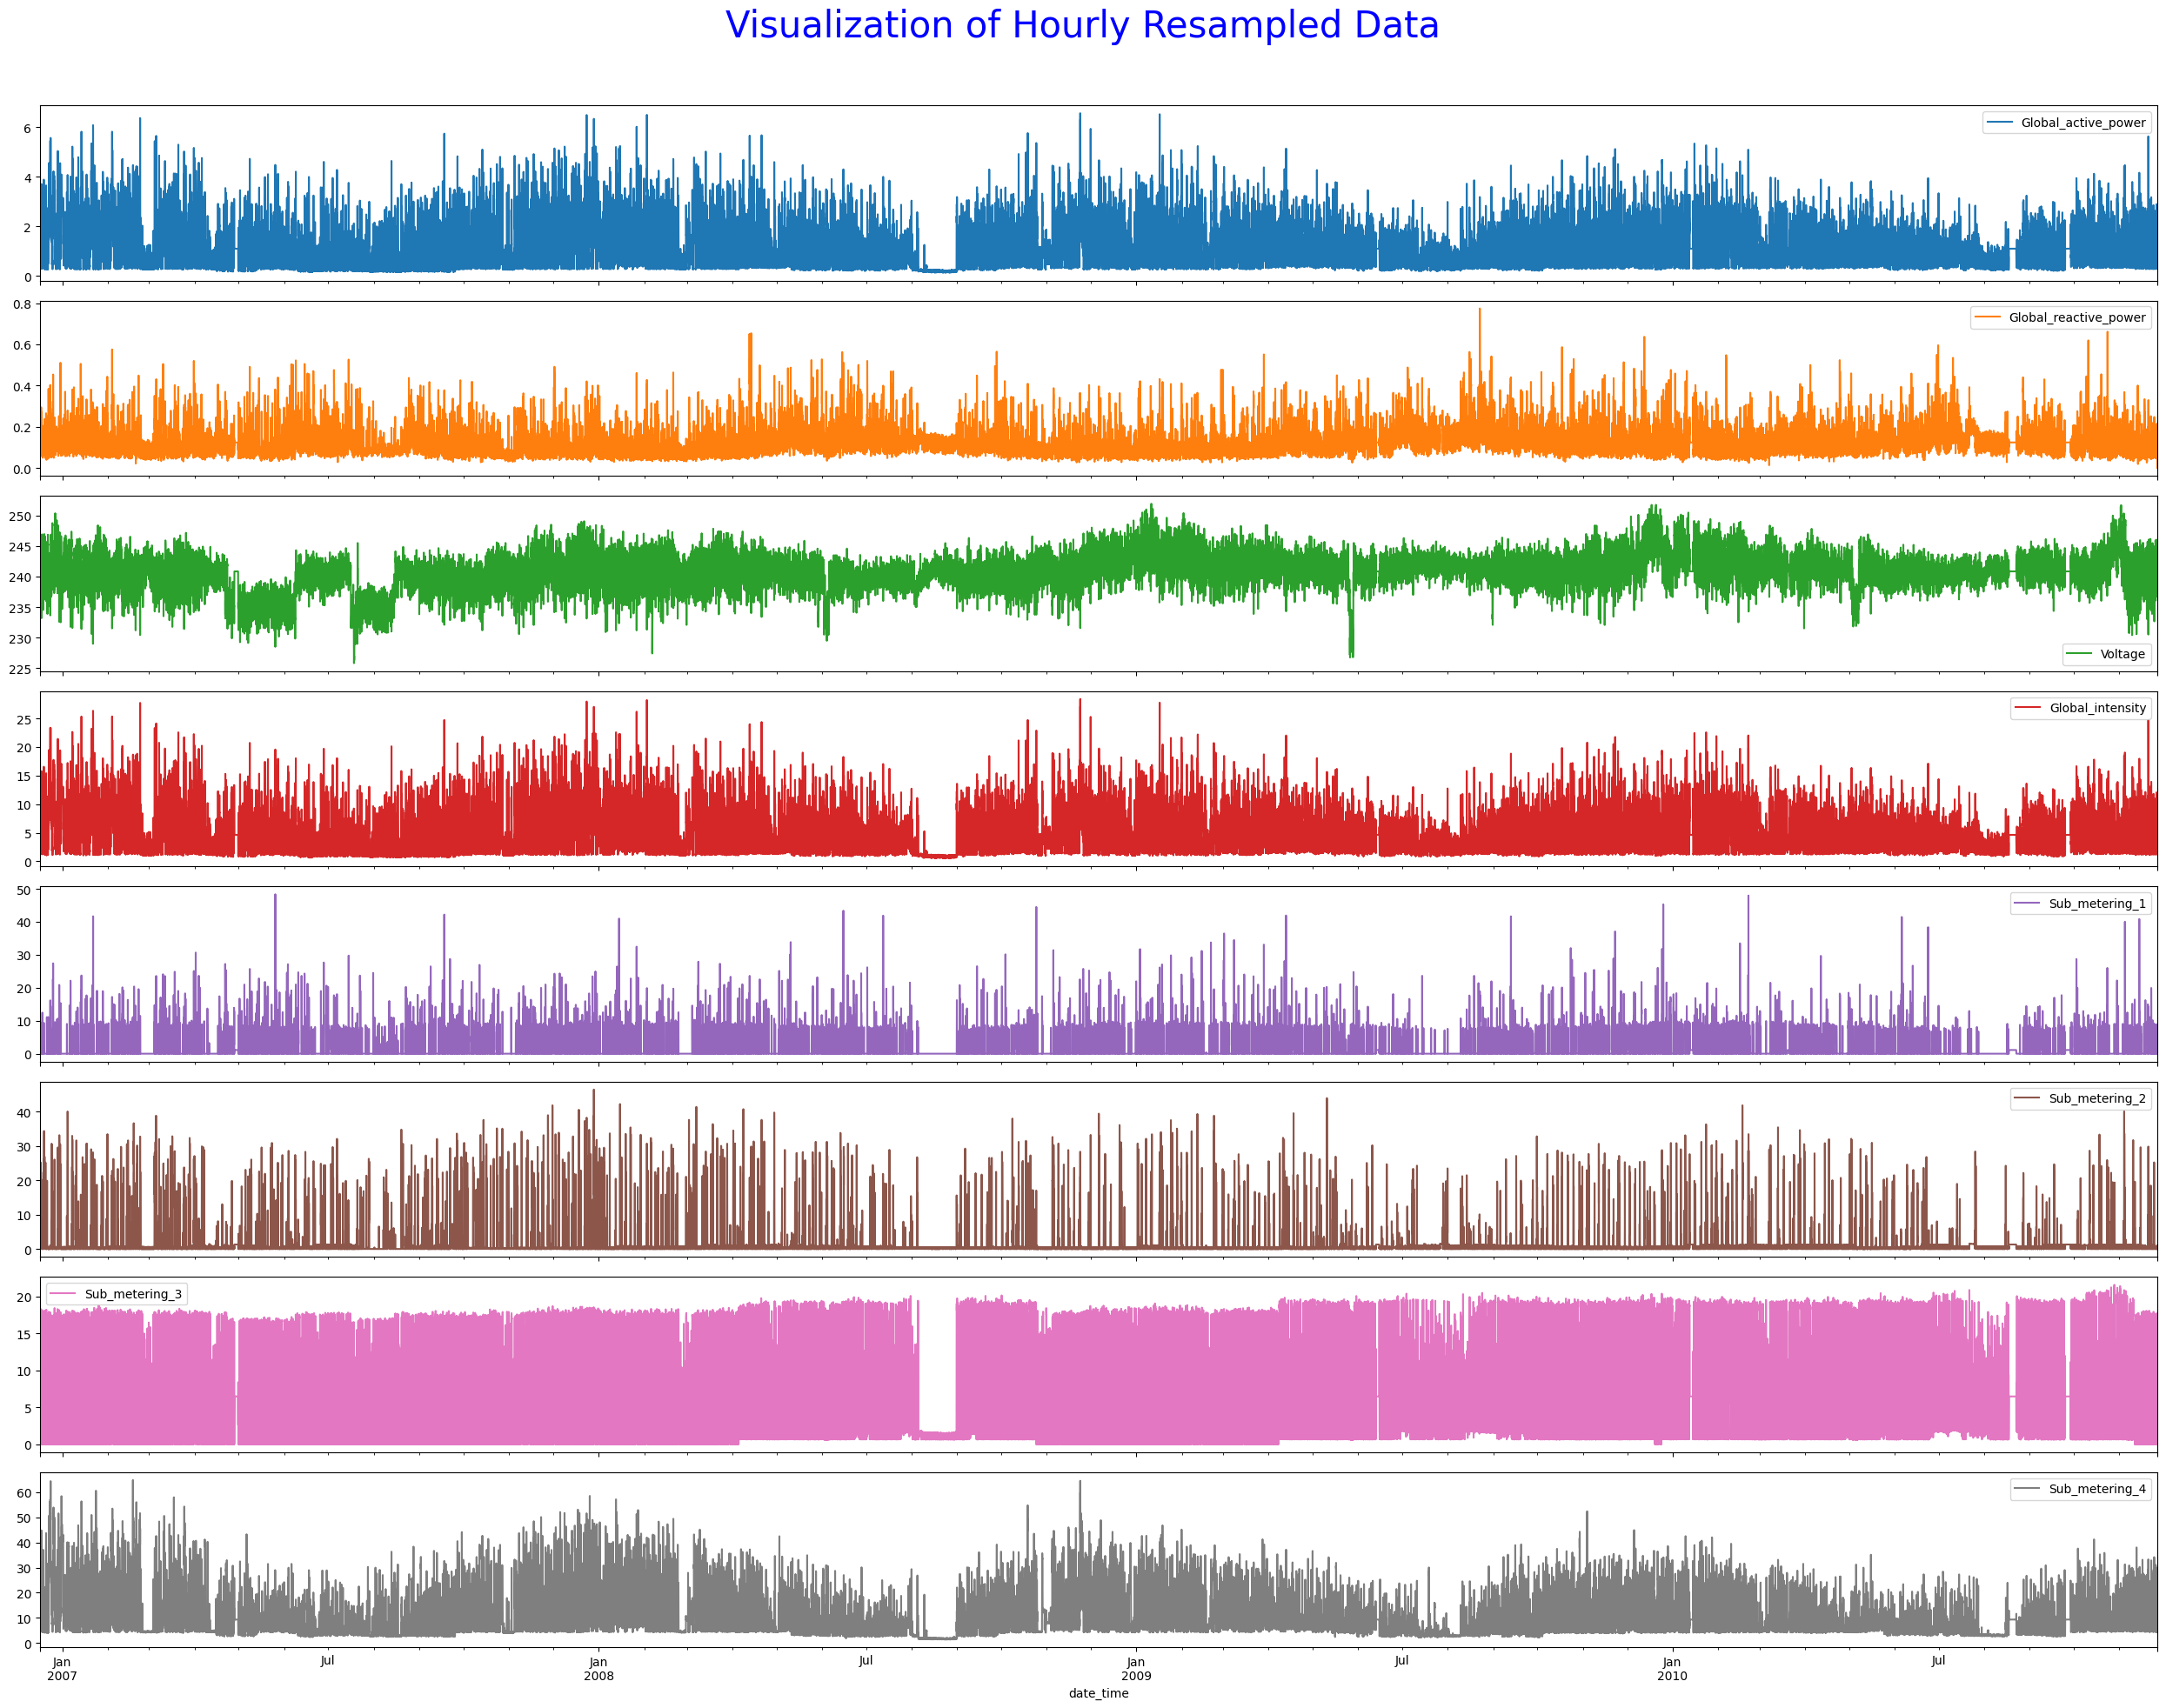

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



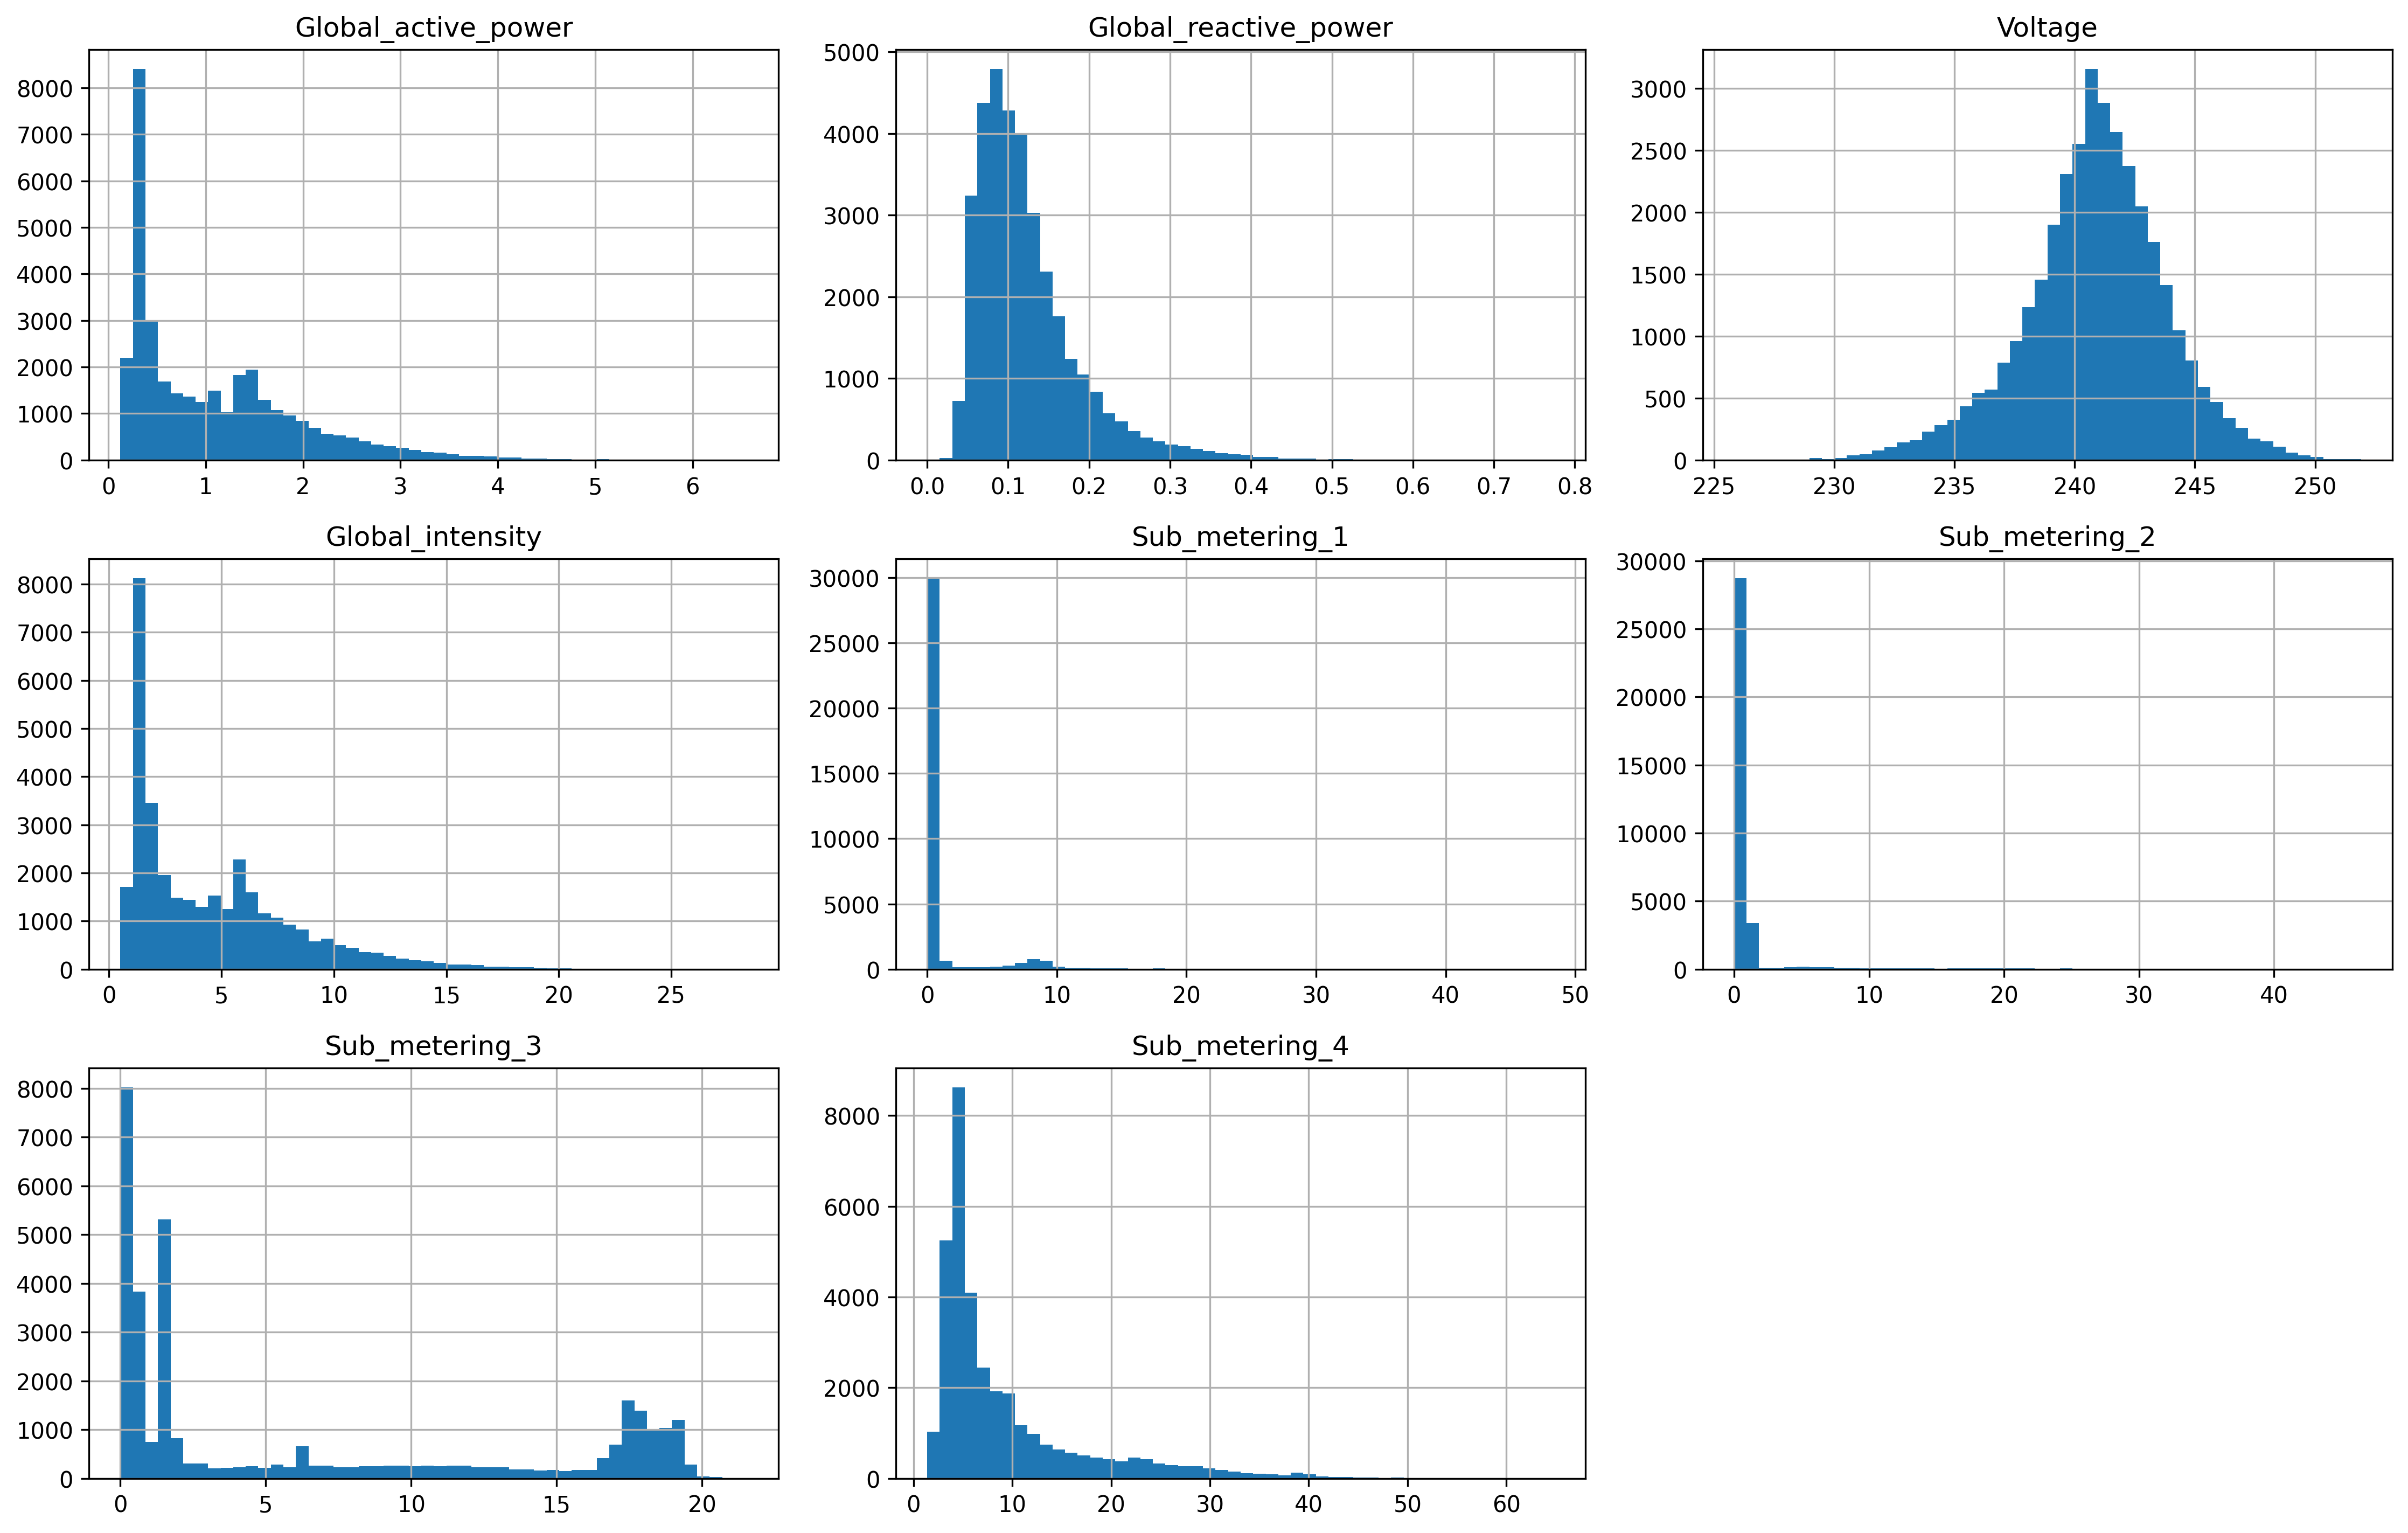

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



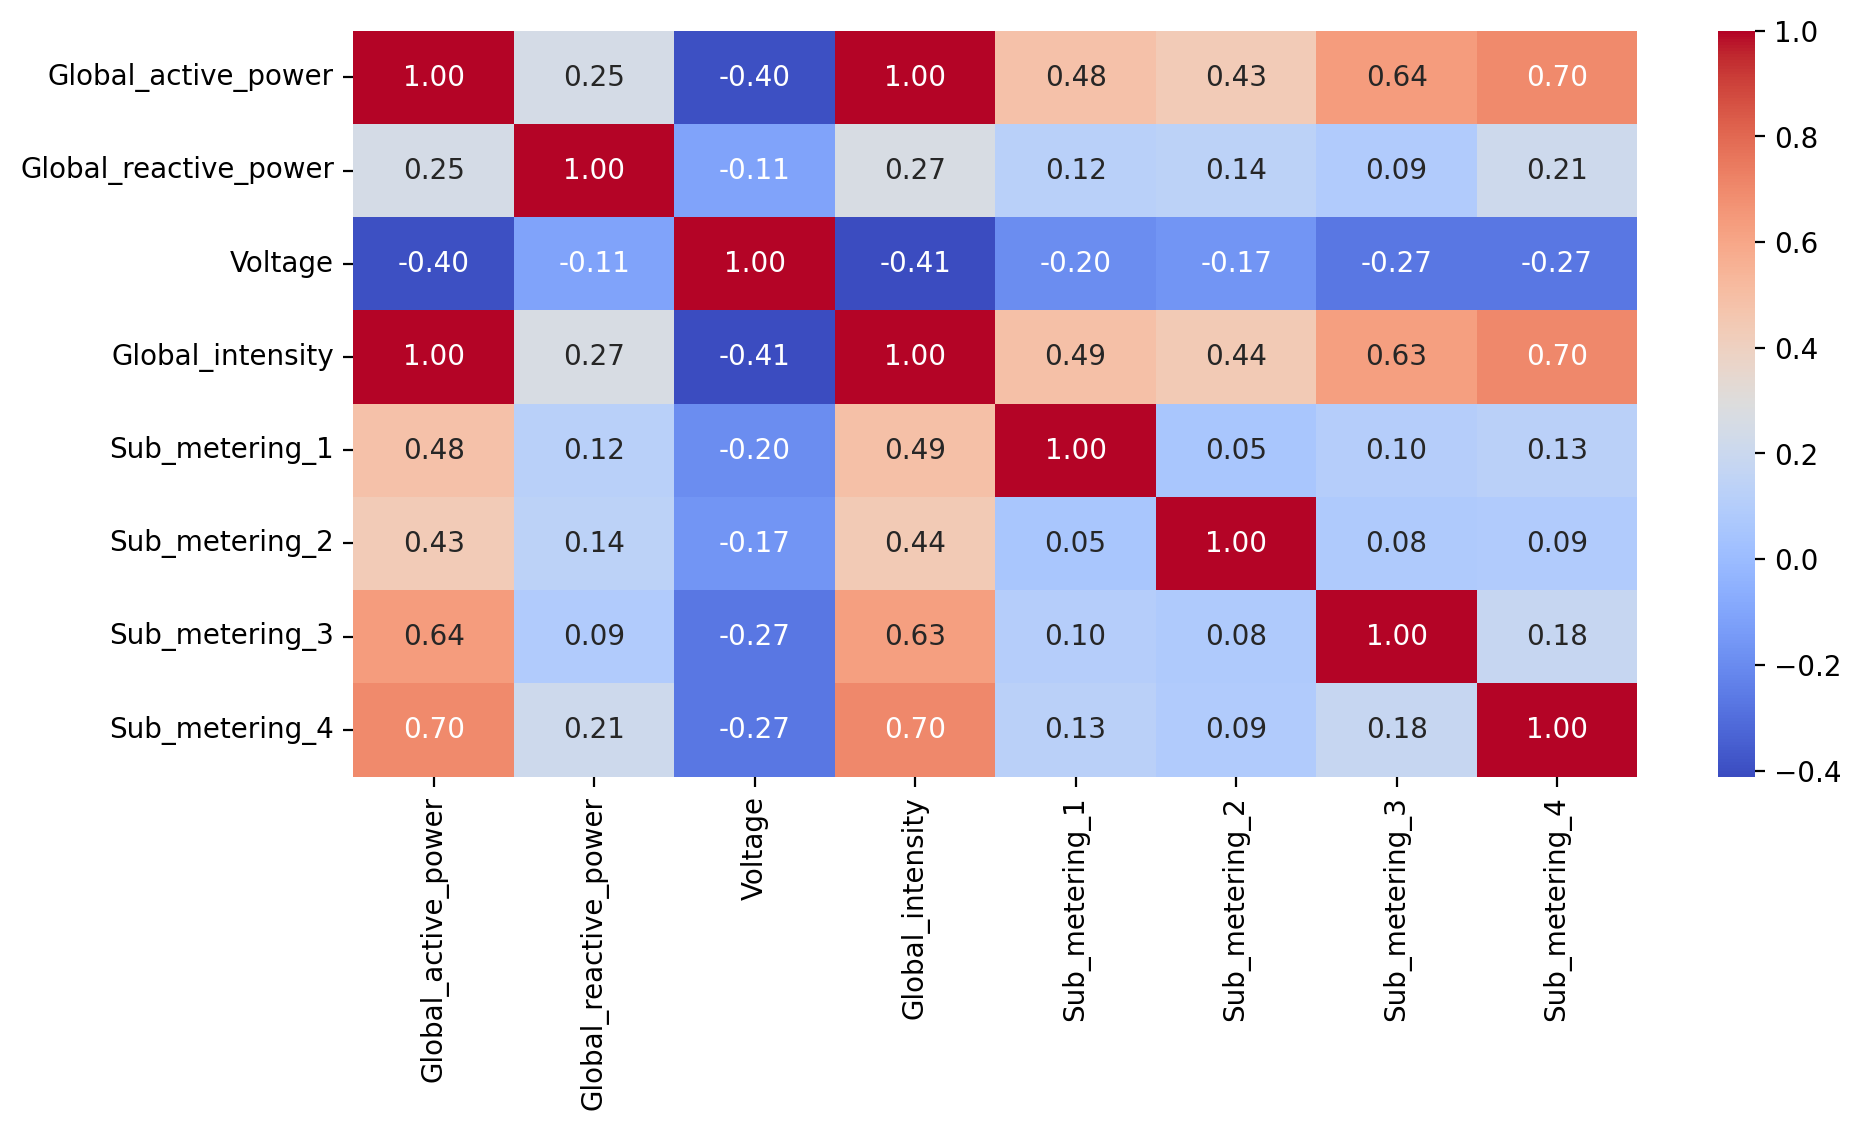

In [14]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [15]:
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)
df1

# Feature Engineering

In [ ]:
# Create new columns for hour, day, quarter, month, and year
#df1['hour'] = hourly_resampled.index.hour
#df1['month'] = hourly_resampled.index.month
#df1['quarter'] = hourly_resampled.index.quarter
#df1['year'] = hourly_resampled.index.year
#df1['week_of_year'] = hourly_resampled.index.isocalendar().week
#df1['day_of_week'] = hourly_resampled.index.dayofweek
#df1['day_of_month'] = hourly_resampled.index.day
#df1['day_of_year'] = hourly_resampled.index.dayofyear
#df1

## Data Normalization

In [17]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# See the scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, 0.        , 0.        ,
        0.        ]])

# Train-Test Splitting

In [18]:
# Define sequence length and features
sequence_length = 1             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27670, 1, 6), (27670,), (6918, 1, 6), (6918,))

# LSTM model

In [19]:
# Create the LSTM model

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

'''model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
'''
'''model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu', return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units=1, kernel_regularizer=l2(0.001)))
'''
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.05)

# Fit the model
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/20
396/396 - 6s - 16ms/step - loss: 0.0133 - val_loss: 0.0089
Epoch 2/20
396/396 - 7s - 17ms/step - loss: 0.0100 - val_loss: 0.0084
Epoch 3/20
396/396 - 2s - 6ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 4/20
396/396 - 2s - 4ms/step - loss: 0.0096 - val_loss: 0.0081
Epoch 5/20
396/396 - 1s - 4ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 6/20
396/396 - 3s - 6ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 7/20
396/396 - 2s - 4ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 8/20
396/396 - 3s - 8ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 9/20
396/396 - 2s - 4ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 10/20
396/396 - 2s - 6ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 11/20
396/396 - 3s - 6ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 12/20
396/396 - 2s - 4ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 13/20
396/396 - 2s - 4ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 14/20
396/396 - 3s - 8ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 15/20
396/396 - 3s - 

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=528, validation_data=(X_test, y_test))

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0088 - val_loss: 0.0062
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0088 - val_loss: 0.0060
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0087 - val_loss: 0.0063
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/st

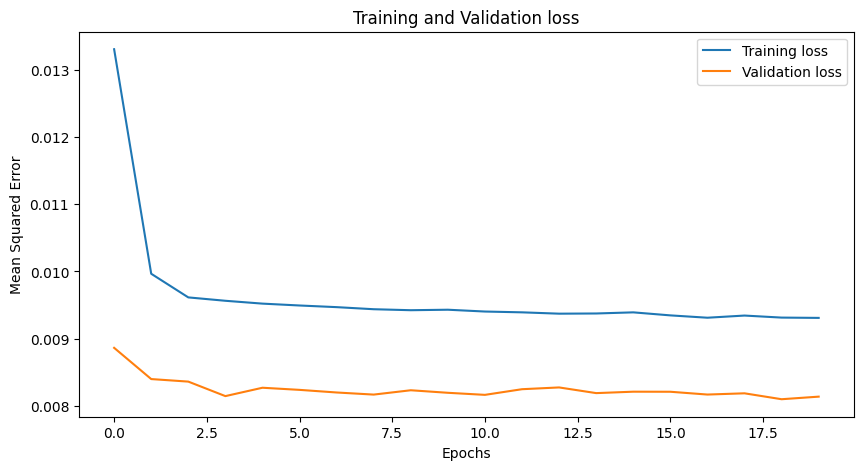

In [23]:
# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [25]:
# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

865/865 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Train MAE: 0.519
Train MSE: 0.431
Train RMSE: 0.656
Train R² score: 0.500

Test MAE: 0.464
Test MSE: 0.337
Test RMSE: 0.581
Test R² score: 0.356


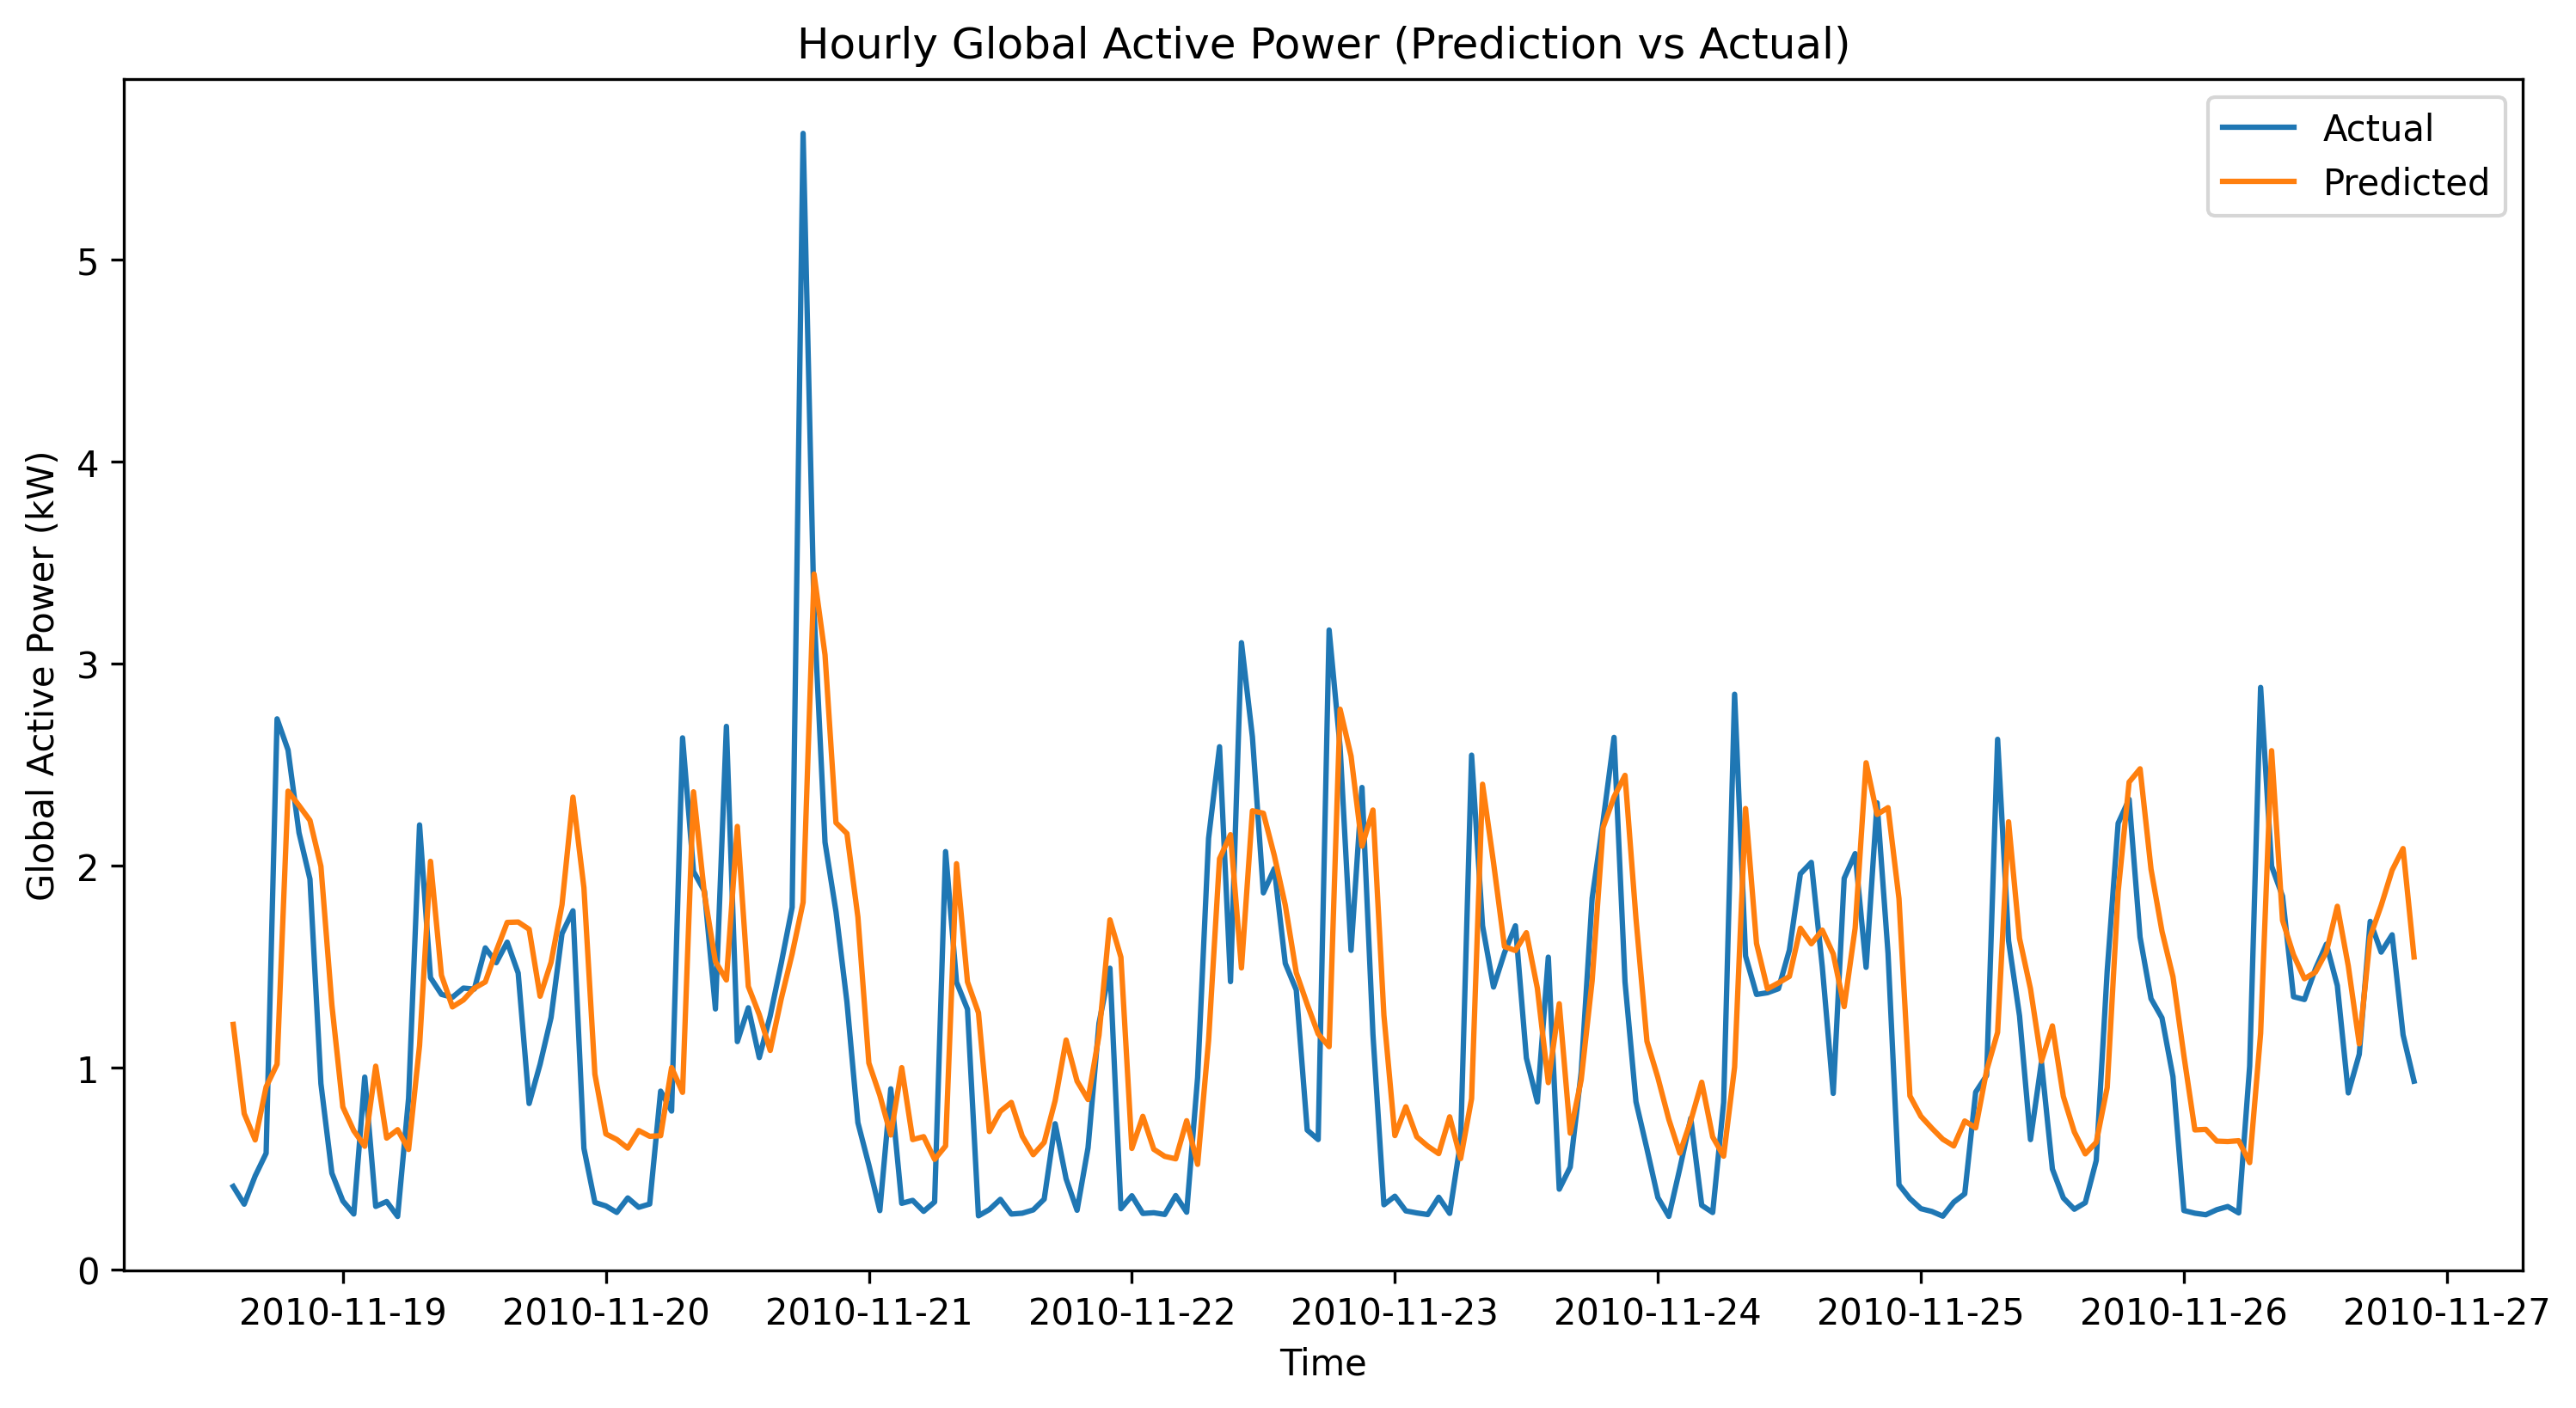

In [38]:
# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

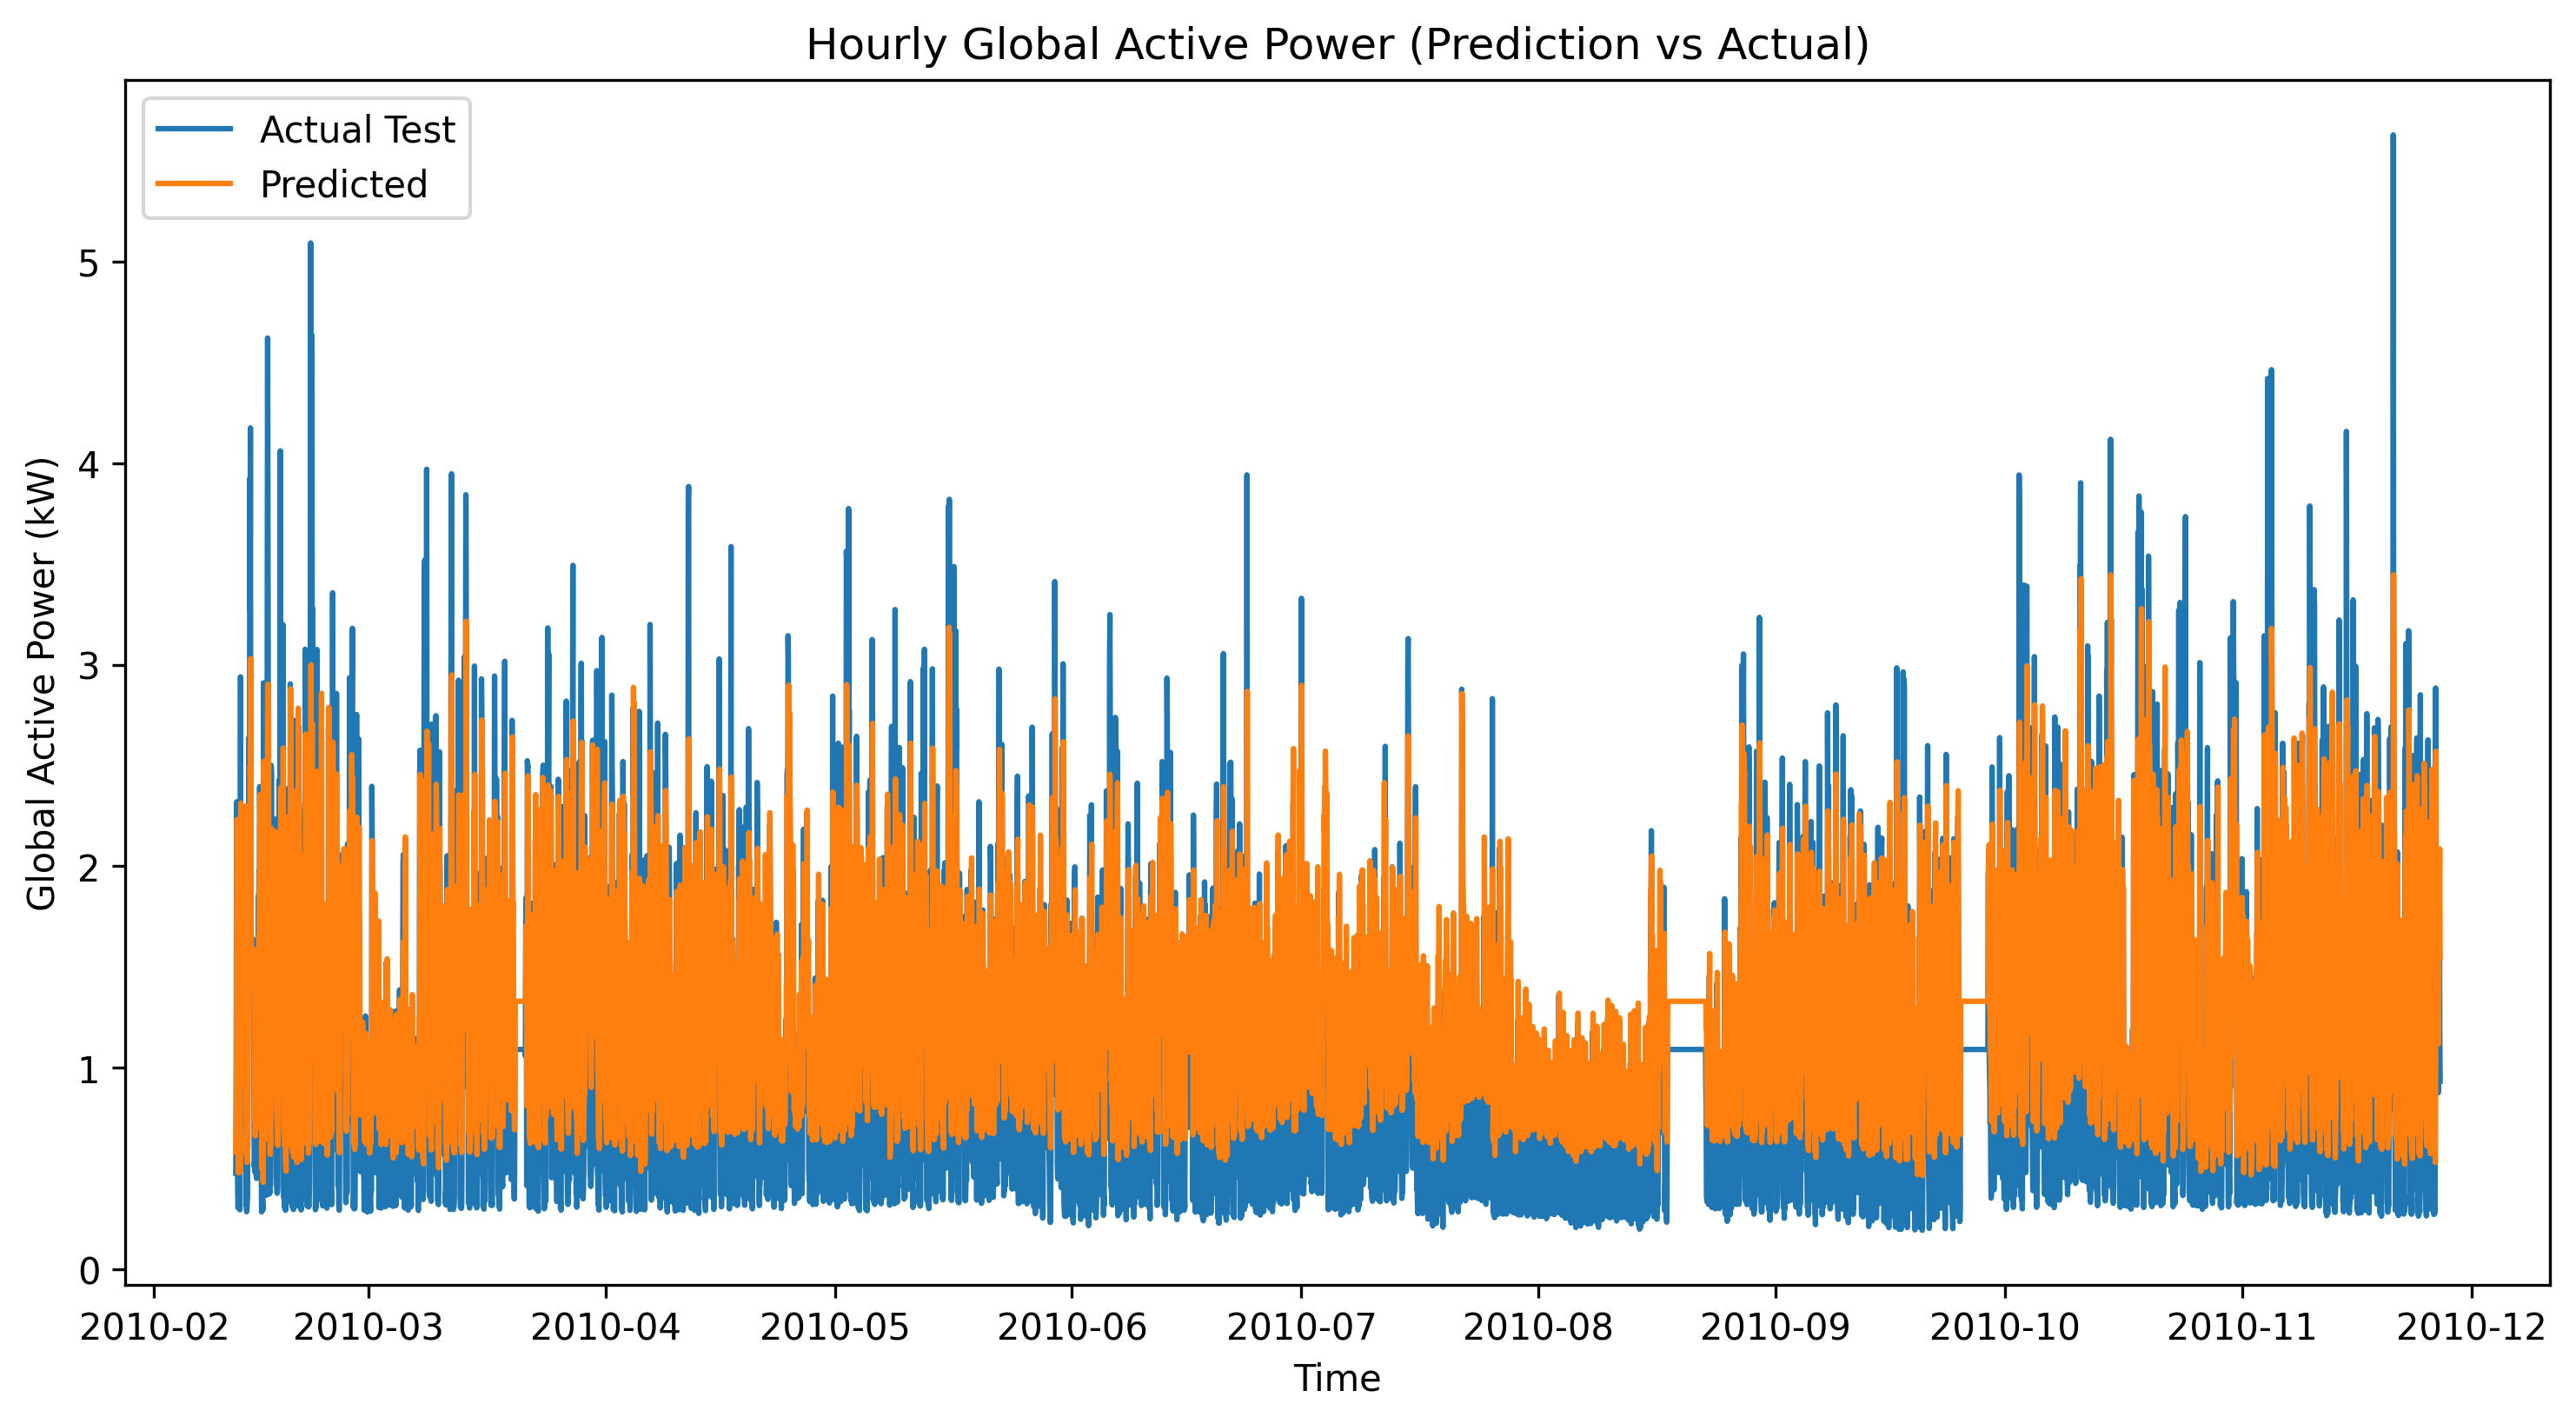

In [37]:
# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-X_test.shape[0]:], true_y_test, label='Actual Test')
plt.plot(df1.index[-X_test.shape[0]:], pred_y_test, label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()